In [47]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime
import xray
import pandas as pd

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [2]:
ds_surf = xray.open_dataset('../data/wmt_surface.nc')
ds_mixing = xray.open_dataset('../data/wmt_upper_0671m.nc')
ds = ds_surf.merge(ds_mixing)
ds

<xray.Dataset>
Dimensions:          (sigma0: 399, time: 438)
Coordinates:
  * sigma0           (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 ...
  * time             (time) datetime64[ns] 2005-01-06T05:00:00 ...
Data variables:
    heat_flux        (time, sigma0) float64 -6.351e+04 -3.551e+04 -7.526e+04 ...
    heat_wthmass     (time, sigma0) float64 -7.799e+04 -3.679e+04 -7.753e+04 ...
    salt_IO_plus_AO  (time, sigma0) float64 -2.287e+04 -1.476e+04 -2.551e+04 ...
    salt_AI_plus_AO  (time, sigma0) float64 -2.287e+04 -1.476e+04 -2.551e+04 ...
    salt_AI          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AO          (time, sigma0) float64 -2.287e+04 -1.476e+04 -2.551e+04 ...
    salt_IO          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_brine    (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_melt     (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_wsltmass    (time, sigma0) float

In [93]:
wmt = ds.mean(dim='time')/1e6 # values in sv
wmt
wmt_year = ds.groupby('time.year').mean(dim='time')

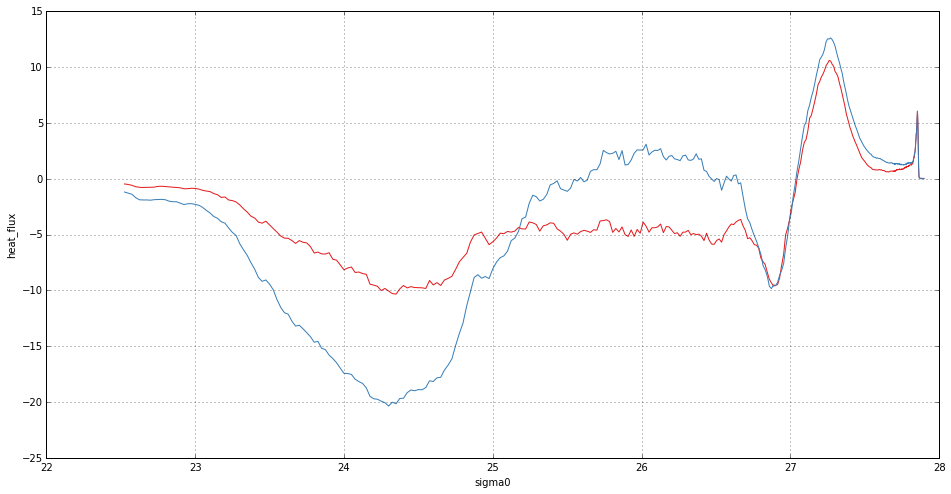

In [4]:
(wmt.heat_surfflux + wmt.heat_sw).plot()
wmt.heat_flux.plot()
plt.grid()

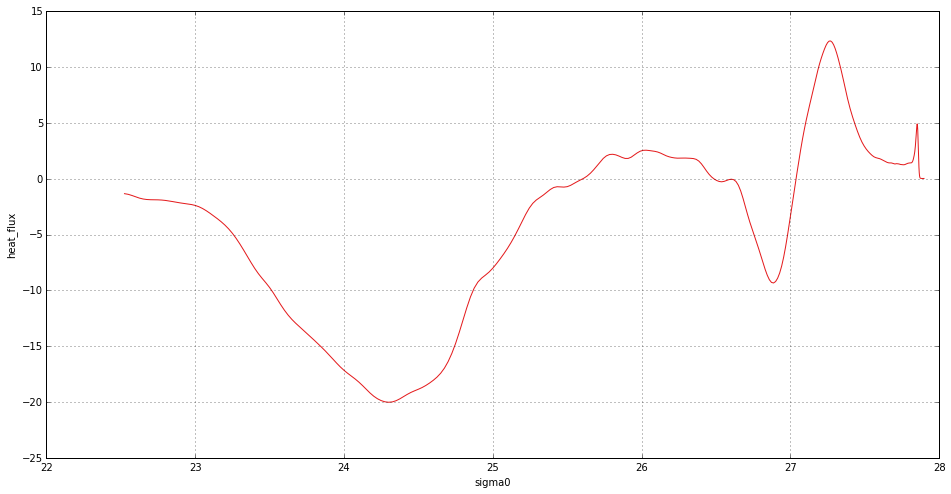

In [5]:
from scipy.ndimage import gaussian_filter1d
wmt_sm = wmt.copy(deep=True)
for k in wmt_sm.data_vars.keys():
    da = wmt_sm[k]
    da.data = gaussian_filter1d(da, 2)
wmt_sm.heat_flux.plot()
plt.grid()

In [6]:
# formation
sig0_mid = 0.5*(wmt.sigma0.data[1:] + wmt.sigma0[:-1])
dsig = wmt.sigma0.data[1:] - wmt.sigma0.data[:-1]
wmf = xray.Dataset(coords={'sigma0': ('sigma0', sig0_mid)})
for k in wmt_sm.data_vars.keys():
    wmf[k] = -xray.DataArray(np.diff(wmt_sm[k]) / dsig, coords={'sigma0': sig0_mid}, dims='sigma0')
wmf

<xray.Dataset>
Dimensions:          (sigma0: 398)
Coordinates:
  * sigma0           (sigma0) float64 22.54 22.56 22.59 22.61 22.64 22.66 ...
Data variables:
    heat_flux        (sigma0) float64 2.356 4.131 4.873 4.468 3.262 1.857 ...
    heat_wthmass     (sigma0) float64 0.01377 0.03384 0.05731 0.08558 0.1316 ...
    salt_IO_plus_AO  (sigma0) float64 0.08975 0.141 0.1454 0.1404 0.1823 ...
    salt_AI_plus_AO  (sigma0) float64 0.08893 0.139 0.1415 0.1345 0.1755 ...
    salt_AI          (sigma0) float64 6.34e-06 -2.588e-05 -7.845e-05 ...
    salt_AO          (sigma0) float64 0.08892 0.139 0.1416 0.1346 0.1756 ...
    salt_IO          (sigma0) float64 0.000823 0.00203 0.003836 0.005779 ...
    salt_IO_brine    (sigma0) float64 -0.0006597 -0.0007508 -0.0003094 ...
    salt_IO_melt     (sigma0) float64 0.001483 0.00278 0.004145 0.005648 ...
    salt_wsltmass    (sigma0) float64 -0.02675 -0.07755 -0.147 -0.2385 ...
    salt_surfflux    (sigma0) float64 0.1107 0.181 0.1941 0.1771 0.1888 0.26

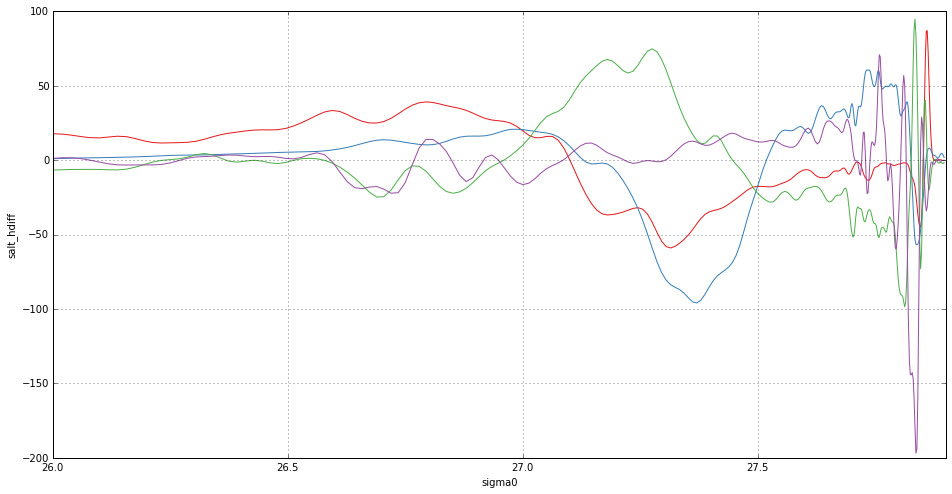

In [7]:
wmf.salt_AO.plot()
wmf.salt_IO.plot()
wmf.salt_vdiff.plot()
wmf.salt_hdiff.plot()
plt.xlim([26,27.9])
plt.grid()

In [133]:
# add neutral density
sig_vs_gam = np.load('sigma_vs_gamma.npz')
gam = np.interp(wmt_sm.sigma0, sig_vs_gam['sigma0'][::-1], sig_vs_gam['gamman'][::-1])
#plt.plot(gam)
wmt_sm['gamman'] = xray.DataArray(gam, dims=wmt_sm.sigma0.dims, coords=wmt_sm.sigma0.coords)
gam_wmf = np.interp(wmf.sigma0, sig_vs_gam['sigma0'][::-1], sig_vs_gam['gamman'][::-1])
wmf['gamman'] = xray.DataArray(gam_wmf, dims=wmf.sigma0.dims, coords=wmf.sigma0.coords)


# Transformation Rates #

In [107]:
# use neutral density for plots
wmt_sm = wmt_sm.swap_dims({'sigma0': 'gamman'})

In [139]:
# sigma_0
wmass_names_sig0 = {'T/MW': 26.0, 'AAIW': 27.0, 'UCDW': 27.55, 'LCDW': 27.72, 'AABW': 27.82}

wmass_names_gam = ['TW', 'SAMW', 'AAIW', 'UCDW', 'LCDW', 'AABW']
wmass_vals_gam =[26.0,26.6,27.0,27.5,28.0,28.2,29]

#wmass_boundaries = [('T/MW', (26.0,27.0)), ('AAIW', (27.0,27.55)),
#                    ('UCDW', (27.55,27.72)), ('LCDW', (27.72, 27.82)),
#                    ('AABW', (27.82,29.))]

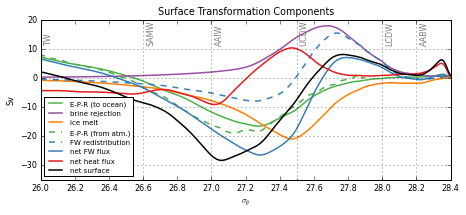

In [141]:
mcols = bmap.mpl_colors
plt.rcParams['legend.handlelength'] = 2.5
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)
colors = bmap.mpl_colors[2:]

wmt_sm.salt_AO.plot(ax=ax, color=colors[0])
wmt_sm.salt_IO_brine.plot(ax=ax, color=colors[1])
wmt_sm.salt_IO_melt.plot(ax=ax, color=colors[2])

wmt.salt_AI_plus_AO.plot(ls='--', color=colors[0], ax=ax)
redist = wmt_sm.salt_IO - wmt_sm.salt_AI
redist.plot(ls='--', color=mcols[1], ax=ax)

wmt_sm.salt_IO_plus_AO.plot(color=mcols[1])
hf = wmt_sm.heat_surfflux + wmt_sm.heat_sw

hf.plot(color=mcols[0], ax=ax)

(wmt_sm.salt_IO_plus_AO + hf).plot(color='k', ax=ax)

ax.legend(['E-P-R (to ocean)', 'brine rejection', 'ice melt',
            'E-P-R (from atm.)','FW redistribution', 'net FW flux',
           'net heat flux', 'net surface'],
          loc='lower left')
ax.grid()
ax.set_title('Surface Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
#ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')
ax.set_ylabel('Sv')

ax.set_xticks(np.arange(26,28.41,0.2), minor=False);
ax.set_xticks(wmass_vals_gam[:-1], minor=True);
#ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dlow, dhigh in zip(wmass_names_gam, wmass_vals_gam[:-1], wmass_vals_gam[1:]):
    ax.text(dlow+0.02, 11, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')
#for name, dens in wmass_names.iteritems():
#    ax.text(dens+0.02, 11, name, color='0.5',
#            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,28.4])
ax.set_ylim([-35,20])
plt.tight_layout()
plt.savefig('../figures_ice_moc/transformation_surface_gamman.pdf')


#plt.savefig('../figures_ice_moc/transformation_5day_hires.pdf')

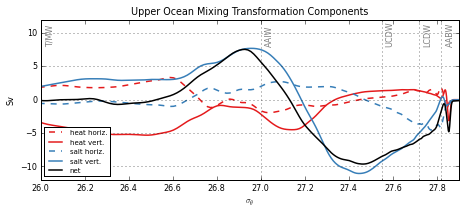

In [11]:
mcols = bmap.mpl_colors
plt.rcParams['legend.handlelength'] = 2.5
plt.rcParams['font.size'] = 8

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)

wmt_sm.heat_hdiff.plot(ax=ax, color=mcols[0], ls='--')
(wmt_sm.heat_kpp + wmt_sm.heat_vdiff).plot(ax=ax, color=mcols[0], ls='-')
wmt_sm.salt_hdiff.plot(ax=ax, color=mcols[1], ls='--')
(wmt_sm.salt_kpp + wmt_sm.salt_vdiff).plot(ax=ax, color=mcols[1], ls='-')

all_mixing = (wmt_sm.salt_hdiff + wmt_sm.salt_kpp + wmt_sm.salt_vdiff +
              wmt_sm.heat_hdiff + wmt_sm.heat_kpp + wmt_sm.heat_vdiff)

all_mixing.plot(ax=ax, color='k')

ax.legend(['heat horiz.', 'heat vert.', 'salt horiz.', 'salt vert.', 'net'],
          loc='lower left')
ax.grid()
ax.set_title('Upper Ocean Mixing Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
#ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')
ax.set_ylabel('Sv')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 8, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,27.9])
ax.set_ylim([-12,12])
plt.tight_layout()

plt.savefig('../figures_ice_moc/transformation_mixing_up670_sigma0.pdf')



In [134]:
wmf = wmf.swap_dims({'sigma0': 'gamman'})
#wmf = wmf.swap_dims({'gamman': 'sigma0'})

ValueError: cannot swap from dimension 'sigma0' because it is not an existing dimension

(-100, 100)

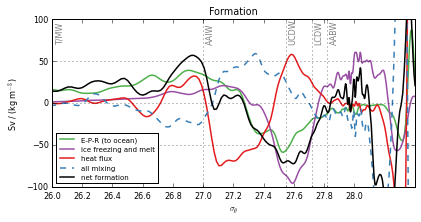

In [138]:
fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)

wmf.salt_AO.plot(ax=ax, color=colors[0])
wmf.salt_IO.plot(ax=ax, color=colors[1])
#wmf.salt_IO_brine.plot(ax=ax, color=colors[1])
#wmf.salt_IO_melt.plot(ax=ax, color=colors[2])

(wmf.heat_surfflux + wmf.heat_sw).plot(color=mcols[0], ax=ax)

(wmf.salt_hdiff + wmf.salt_kpp + wmf.salt_vdiff + #).plot(ax=ax, color=mcols[1], ls=':')
wmf.heat_hdiff + wmf.heat_kpp + wmf.heat_vdiff).plot(ax=ax, color=mcols[1], ls='--')

(wmf.salt_hdiff + wmf.salt_kpp + wmf.salt_vdiff +
 wmf.heat_hdiff + wmf.heat_kpp + wmf.heat_vdiff +
 wmf.salt_AO + wmf.salt_IO + wmf.heat_surfflux + wmf.heat_sw
).plot(ax=ax, color='k')

ax.legend(['E-P-R (to ocean)', 'ice freezing and melt', 'heat flux',
          'all mixing','net formation'],
         loc='lower left')

ax.grid()
ax.set_title('Formation')
ax.set_xlabel(r'$\sigma_\theta$')
ax.set_ylabel(r'Sv / (kg m$^{-3}$)')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 70, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

#ax.set_xlim([26,27.9])
ax.set_xlim([26,28.4])
ax.set_ylim([-100,100])
#plt.tight_layout()

#plt.savefig('../figures_ice_moc/formation_continuous_sigma0.pdf')

#plt.savefig('../figures_ice_moc/transformation_surface_sigma0.pdf')


#plt.savefig('../figures_ice_moc/transformation_5day_hires.pdf')

## Temporal Variability ##

In [13]:
ds_ice = xray.open_dataset('../data/ice_in_rho_space.nc')
ds_ice

<xray.Dataset>
Dimensions:        (sigma0: 399, time: 438)
Coordinates:
  * sigma0         (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 22.68 ...
  * time           (time) datetime64[ns] 2005-01-06T05:00:00 ...
Data variables:
    heff           (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    concentration  (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    outcrop_area   (time, sigma0) float64 4.745e+08 2.369e+08 4.845e+08 ...

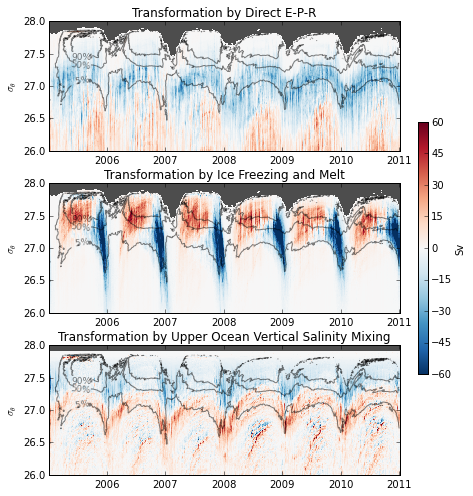

In [92]:
show_heat = False

if show_heat:
    nrows=4
    hspace=0.32
else:
    nrows=3
    hspace=0.25

fig, axes = plt.subplots(nrows=nrows, subplot_kw={'axisbg': '0.3'}, figsize=(6.5,7.))

mask = (ds_ice.outcrop_area>1e9)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.85, top=0.95, hspace=hspace)
plot_kwargs = dict(vmin=-60, vmax=60, add_colorbar=False, rasterized=True)


Tlab = pd.to_datetime(ds.time[40].data).toordinal()

### Atm to Ocean ###
(ds.salt_AO.where(mask).T/1e6).plot(ax=axes[0], **plot_kwargs)
### Ice to Ocean ###
(ds.salt_IO.where(mask).T/1e6).plot(ax=axes[1], **plot_kwargs)
### Heat Flux ###
if show_heat:
    heat = (ds.heat_surfflux + ds.heat_sw)
    (heat.where(mask).T/1e6).plot(ax=axes[2], **plot_kwargs)
### Mixing
pc = ((ds.salt_vdiff + ds.salt_kpp).T/1e6).plot(ax=axes[nrows-1], **plot_kwargs)

for ax in axes:
    c = (ds_ice.concentration.where(mask).T*100).plot.contour(ax=ax,
                levels=[5,50,90], colors='k', linewidth=0.25, alpha=0.5,
                add_colorbar=False)
    plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.1),(Tlab, 27.3),(Tlab, 27.5)],
          fontsize=9, inline_spacing=3)
    ax.set_ylim([26.0,28])
    ax.set_ylabel(r'$\sigma_\theta$')
    ax.set_xlabel('')

axes[0].set_title('Transformation by Direct E-P-R')
axes[1].set_title('Transformation by Ice Freezing and Melt')
if show_heat:
    axes[2].set_title('Transformation by Surface Heat Flux')
axes[nrows-1].set_title('Transformation by Upper Ocean Vertical Salinity Mixing')

cbax = fig.add_axes([0.89,0.25,0.02,0.5])
cb = plt.colorbar(pc, cax=cbax)
cb.set_label('Sv')

if show_heat:
    fig.savefig('../figures_ice_moc/fw_transformation_timeseries_with_heat.pdf')
else:
    fig.savefig('../figures_ice_moc/fw_transformation_timeseries.pdf')    

(26, 28)

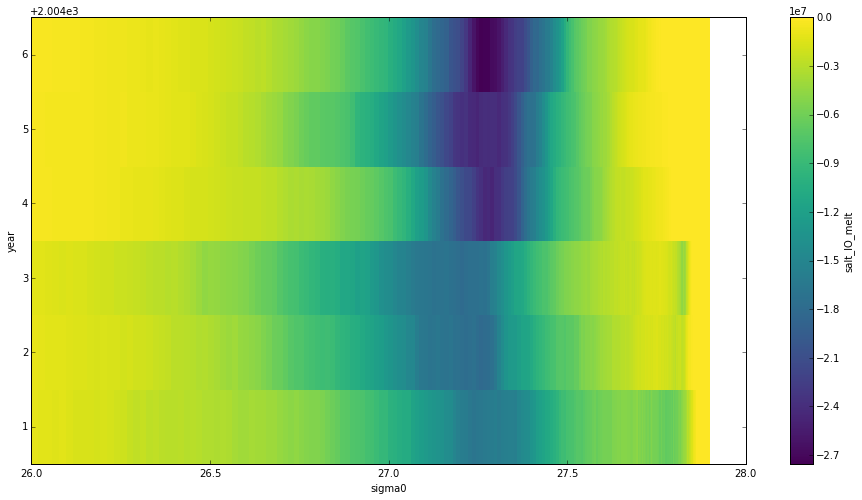

In [98]:
wmt_year.salt_IO_melt.plot()
plt.xlim([26,28])